In [1]:
# One-stroke Kolam Generation 210419
%matplotlib notebook

import sys
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from datetime import datetime

import matplotlib.animation as animation

import timeit
from timeit import default_timer as timer

np.random.seed(seed=1)
import tensorflow as tf

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
class KolamDraw(object):
    
    def __init__(self,ND,OR,ORCi,ORCj,IR):
 
        self.ND = ND
        self.OR = OR
        self.ORCi = ORCi
        self.ORCj = ORCj
        self.IR = IR
    
        self.Nx = ND + 1
        self.A1 = np.ones((self.Nx,self.Nx))*99
        self.F1 = np.ones((self.Nx,self.Nx))
        self.Ns = 2*(self.ND**2 + 1) + 5
        
    def ResetGateMatrix(self):
    
        Nx2 = int(self.Nx/2)
        Nx1 = self.Nx - 1
        A = self.A1*1
        F = self.F1*1
        
        for i in range(self.Nx):
            A[0,i] = A[i,0] = A[self.Nx-1,i] = A[i,self.Nx-1] = 0
            F[0,i] = F[i,0] = F[self.Nx-1,i] = F[i,self.Nx-1] = 0
        for i in range(1,self.Nx-1):
            A[i,i] = A[i,self.Nx-1-i] = 1
            F[i,i] = F[i,self.Nx-1-i] = 0
        for i in range(Nx2):
            for j in range(Nx2):
                if ((i-self.ORCi)**2 + (j-self.ORCj)**2) >= self.OR*self.OR:
                    if ((i-(self.Nx-1-self.ORCi))**2 + (j-self.ORCj)**2) >= self.OR*self.OR:
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-j] = 0
                        F[i,j] = F[j,i] = F[Nx1-1-i,Nx1-j] = F[Nx1-j,Nx1-j] = -1
                    if (i-self.ND/2)**2 + (j-self.ND/2)**2 <= self.IR**2:
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-j] = 0
                        F[i,j] = F[j,i] = F[Nx1-i,Nx1-j] = F[Nx1-j,Nx1-j] = -1
        return(A, F)
                        
    def toss(self,bias):
        x = np.random.randint(0,1000)/1000
        # print (x)
        if x > bias:
            return (1)
        else:
            return (0)
                         
    def AssignGates(self,krRef,Kp,Ki):
        
        A, F = self.ResetGateMatrix()
        Asum = A.sum()
        Fsum = F.sum()
        # print ("AssignGates Asum Fsum", Asum, Fsum)
        errAckr = 0.0
        count1 = 0
        count01 = 1
        Nx1 = self.Nx-1
        Nx2 = int(self.Nx/2)

        for i in range (1,Nx2):
            for j in range (i,self.Nx-i):
                errkr = krRef - (count1/count01)
                errAckr = errAckr + errkr
                kr = krRef + Kp*errkr + Ki*errAckr
                
                if F[i,j] == 1:
                    if F[i,j+1] == 1:
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-i] = self.toss(kr)
                        F[i,j] = F[j,i] = F[Nx1-i,Nx1-j] = F[Nx1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j] > 0.9:
                            count1 = count1 + 4
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j]) < 0.1:
                            x = 1
                        else:
                            # x = self.flip.toss(kr)
                            x = self.toss(kr)
                        A[i,j+1] = A[j+1,i] = A[Nx1-i,Nx1-1-j] = A[Nx1-1-j,Nx1-i] = x
                        F[i,j+1] = F[j+1,i] = F[Nx1-i,Nx1-1-j] = F[Nx1-1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j+1] > 0.9:
                            count1 = count1 + 4
                    if F[i,j+1] <= 0:
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j+1]) < 0.1:
                            x = 1
                        else:
                            x = self.toss(kr)
                        A[i,j] = A[j,i] = A[Nx1-i,Nx1-j] = A[Nx1-j,Nx1-i] = x
                        F[i,j] = F[j,i] = F[Nx1-i,Nx1-j] = F[Nx1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j] > 0.9:
                            count1 = count1 + 4
                
                if F[i,j] <= 0:
                    if F[i,j+1] == 1:
                        if (A[i-1,j] + A[i-1,j+1] + A[i,j]) < 0.1:
                            x = 1
                        else:
                            x = self.toss(kr)
                        A[i,j+1] = A[j+1,i] = A[Nx1-i,Nx1-1-j] = A[Nx1-1-j,Nx1-i] = x
                        F[i,j+1] = F[j+1,i] = F[Nx1-i,Nx1-1-j] = F[Nx1-1-j,Nx1-i] = 0
                        count01 = count01 + 4
                        if A[i,j+1] > 0.9:
                            count1 = count1 + 4
        
        return(A, F, kr)
    
    def ReadGates (self, ARead, BRead):
        
        self.A = ARead
        self.F = BRead
        
        return(self.A, self.F)
    
    def NextStep(self,icg,jcg,ce):
        
        icgx = icg + self.ND
        jcx = jcg + self.ND
        icgx2 = int(np.floor(icgx/2))
        jcx2 = int(np.floor(jcx/2))
        #print(ND, icgx2, jcx2)

        calpha = np.mod(ce,2)
        if ce>1:
            cbeta = -1
        else:
            cbeta = 1
        if np.mod(int(icgx + jcx),4) == 0:
            cgamma = -1
        else:
            cgamma = 1
        
        if self.A[icgx2,jcx2]>0.5:
            cg = 1
        else:
            cg = 0
            
        cgd = 1-cg
        calphad = 1-calpha
        nalpha = cg*calpha + cgd*calphad
        nbeta = (cg + cgd*cgamma)*cbeta
        nh = (calphad*cgamma*cgd + calpha*cg)*cbeta
        nv = (calpha*cgamma*cgd + calphad*cg)*cbeta
        ing = int(icg + nh*2)
        jng = int(jcg + nv*2)
        ingp = icg + cgd*(calphad*cgamma - calpha)*cbeta*0.5
        jngp = jcg + cgd*(calpha*cgamma - calphad)*cbeta*0.5
        if nalpha == 0:
            if nbeta == 1:
                ne = 0
            else:
                ne = 2
        if nalpha == 1:
            if nbeta == 1:
                ne = 1
            else:
                ne = 3
        
        # print(calpha, cbeta, cgamma)
                
        # print(ing,jng,ne,ingp,jngp)

        return(ing,jng,ne,ingp,jngp)
    
    def XNextSteps(self,icgo,jcgo,ceo,Ns):
        
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        ijcx[0,:] = [icgo,jcgo]
        cex[0] = ceo
        for i in range(Ns-1):
            ijcx[i+1,0], ijcx[i+1,1], cex[i+1], ijcp[i,0], ijcp[i,1] = self.NextStep(
                ijcx[i,0], ijcx[i,1], cex[i])
        return (ijcx, cex, ijcp)

    def PathCount(self):
        
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        Flag1 = Flag2 = 0
        isx = 0
        isa = 0
         
        ijcx[0,0] = 2*np.random.randint(0,2) - 1
        ijcx[0,1] = 2*np.random.randint(0,2) - 1
        #ijcx[0,0] = ijcx[0,1] = 1
        cex[0] = 0
            
        while isa < Ns-2:
                
            isa = isa + 1
                              
            ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
            if int(ijcx[isa,0]) == int(ijcx[0,0]):
                if int(ijcx[isa,1]) == int(ijcx[0,1]):
                    if int(cex[isa]) == int(cex[0]):
                        Flag1 = 1
                        isx = isa
                        isa = Ns - 1
 
                # print(ith,isa,ijcx[isa,:])
        #print ('PathCount', ijcx[0,:], isx)
        return(isx)
    
    def PathCountRandom(self, irand, jrand):
        
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        Flag1 = Flag2 = 0
        isx = 0
        isa = 0
         
        ijcx[0,0] = 2*irand - 1
        ijcx[0,1] = 2*jrand - 1
        #ijcx[0,0] = ijcx[0,1] = 1
        cex[0] = 0
            
        while isa < Ns-2:
                
            isa = isa + 1
                              
            ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
            if int(ijcx[isa,0]) == int(ijcx[0,0]):
                if int(ijcx[isa,1]) == int(ijcx[0,1]):
                    if int(cex[isa]) == int(cex[0]):
                        Flag1 = 1
                        isx = isa
                        isa = Ns - 1
 
                # print(ith,isa,ijcx[isa,:])
        #print ('PathCount', ijcx[0,:], isx)
        return(isx)
    

    def Dice(self,krRef,Kp,Ki,Nthr):
        
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        krx = np.zeros((Nthr))
        ith = int(0)
        ithx = int(0)
        ismax = int(0)
        
        while ith < Nthr:
            
            self.A, self.F, krx[ith] = self.AssignGates(krRef,Kp,Ki)
            Asum = self.A.sum()
            Fsum = self.F.sum()
            # print ("Dice Asum Fsum", Asum, Fsum)
            #print (self.F)
            Flag1 = Flag2 = 0
            isx = 0
            isa = 0
            ijcx[0,0] = ijcx[0,1] = 1
            cex[0] = 0
            
            while isa < Ns-2:
                
                isa = isa + 1
                              
                ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
                if int(ijcx[isa,0]) == int(ijcx[0,0]):
                    if int(ijcx[isa,1]) == int(ijcx[0,1]):
                        if int(cex[isa]) == int(cex[0]):
                            Flag1 = 1
                            isx = isa
                            isa = Ns - 1
 
                            # print(isa,isx)
                        
            if Flag1 == 1:
                if isx < Ns + 2:
                    Flag2 = 1
                    if isx > ismax:
                        ismax = isx
                        Amax = self.A
                if isx > (Ns/2) - 2:
                    Flag2 = 2
                    ithx = ith
                    ith = int(Nthr + 1)
            
                print("Dice Ns Flag1 Flag2 isx ismax", Ns, Flag1, Flag2, isx, ismax)
                
            ith = ith + 1

        return (self.A, self.F, Amax, isx, ithx, ismax, Flag1, Flag2, krx)
    
    def DiceRandom (self,krRef,Kp,Ki,Nthr):
        
        # This is still work in process and incomplete - Use caution
        Ns = self.Ns
        ijcx = np.zeros((Ns,2))
        cex = np.zeros((Ns))
        ijcp = np.zeros((Ns,2))
        cex[0] = 0
        krx = np.zeros((Nthr))
        ith = int(0)
        ithx = int(0)
        ismax = int(0)
        
        while ith < Nthr:
            
            self.A, self.F, krx[ith] = self.AssignGates(krRef,Kp,Ki)
            Asum = self.A.sum()
            Fsum = self.F.sum()
            
            # Call PathCountRandom here for a number of random times & pick the best 
            for i in range (Nrand):
                PathCountRandom(self, irand, jrand)
            
            # print ("Dice Asum Fsum", Asum, Fsum)
            Flag1 = Flag2 = 0
            isx = 0
            isa = 0
            ijcx[0,0] = ijcx[0,1] = 1

            cex[0] = 0
            
            while isa < Ns-2:
                
                isa = isa + 1
                              
                ijcx[isa,0], ijcx[isa,1], cex[isa], ijcp[isa-1,0], ijcp[isa-1,1] = self.NextStep(ijcx[isa-1,0], ijcx[isa-1,1], cex[isa-1])
                if int(ijcx[isa,0]) == int(ijcx[0,0]):
                    if int(ijcx[isa,1]) == int(ijcx[0,1]):
                        if int(cex[isa]) == int(cex[0]):
                            Flag1 = 1
                            isx = isa
                            isa = Ns - 1
 
                            # print(isa,isx)
                        
            if Flag1 == 1:
                if isx < Ns + 2:
                    Flag2 = 1
                    if isx > ismax:
                        ismax = isx
                        Amax = self.A
                if isx > (Ns/2) - 2:
                    Flag2 = 2
                    ithx = ith
                    ith = int(Nthr + 1)
            
                print("Dice Ns Flag1 Flag2 isx ismax", Ns, Flag1, Flag2, isx, ismax)
                
            ith = ith + 1

        return (self.A, self.F, Amax, isx, ithx, ismax, Flag1, Flag2, krx)        
    
    def EnDeGate(self, ig, jg):
        
        Flag = 0
        Ax = self.A*1
        Fx = self.F*1
        Nx = self.Nx
        if Ax[ig,jg] < 0.1:
            Ax[ig,jg] = Ax[jg,ig] = Ax[Nx-ig-1,Nx-jg-1] = Ax[Nx-jg-1,Nx-ig-1] = 1
            Fx[ig,jg] = Fx[jg,ig] = Fx[Nx-ig-1,Nx-jg-1] = Fx[Nx-jg-1,Nx-ig-1] = 0
            Flag = 1
        if Flag == 0:
            if Ax[ig,jg] > 0.9:
                Ax[ig,jg] = Ax[jg,ig] = Ax[Nx-ig-1,Nx-jg-1] = Ax[Nx-jg-1,Nx-ig-1] = 0
                Fx[ig,jg] = Fx[jg,ig] = Fx[Nx-ig-1,Nx-jg-1] = Fx[Nx-jg-1,Nx-ig-1] = 0
                Flag = -1
        return(Ax, Fx, Flag)
        
    def Refine(self, ksh, prtij, iL, iH):
            
        Ncx = self.PathCount()
        Ns = self.Ns
        Nx2 = int(self.Nx/2)
        # iL should be 1 min & iH should be Nx2 max
        iLx = np.maximum(np.minimum(iL,Nx2),1)
        iHx = np.maximum(np.minimum(iH,Nx2),iLx)
        for ig in range (iLx,iHx):
            for jg in range (ig,self.Nx-1-ig):
                # print ("Refine ig jg", ig, jg)
                Ax = self.A
                Fx = self.F
              
                if self.F[ig,jg] >= 0:
                    if self.toss(ksh) == 1:
                        self.A, self.F, Flag = self.EnDeGate(ig,jg)
                        Nc = self.PathCount()
                        # print ("Refine Nc",Nc)
                        if Nc < Ncx:
                            self.A = Ax
                            self.F = Fx
                        if Nc > Ncx:
                            
                        #if np.mod(ig+jg,int(prtij)) == 0:
                            np.savetxt('ARf.csv',self.A)
                            np.savetxt('FRf.csv',self.F)
                            now = datetime.now()
                            current_time = now.strftime("%H:%M:%S")
                            print ("Refine time ig jg Nc Ncx", current_time, ig, jg, Nc, Ncx)
                            Ncx = Nc
                        if Ncx >= Ns-5:
                            break
        return(Ncx)
    
    def RefineRandom(self, ksh, prtij, iL, iH, Ntrials):
            
        Ncx = self.PathCount()
        Ns = self.Ns
        Nx2 = int(self.Nx/2)
        # iL should be 1 min & iH should be Nx2 max
        iLx = np.maximum(np.minimum(iL,Nx2),1)
        iHx = np.maximum(np.minimum(iH,Nx2),iLx)
        
        for itrial in range (Ntrials):
            ig = np.random.randint (iLx, iHx)
        #for ig in range (iLx,iHx):
            #for jg in range (ig,self.Nx-1-ig):
            jg = np.random.randint (ig, self.Nx-1-ig)
                # print ("Refine ig jg", ig, jg)
            Ax = self.A
            Fx = self.F
              
            if self.F[ig,jg] >= 0:
                if self.toss(ksh) == 1:
                    self.A, self.F, Flag = self.EnDeGate(ig,jg)
                    Nrandomsteps = 2
                    Ncr = np.zeros(Nrandomsteps)
                    for krandom in range (Nrandomsteps):
                        itemp = np.random.randint(0,iHx)
                        Ncr[krandom] = self.PathCountRandom(itemp,-itemp)
                    #Nc = self.PathCount()
                    Nc = np.int32(np.amax(Ncr))
                    # print ("Refine Nc",Nc)
                    if Nc < Ncx:
                        self.A = Ax
                        self.F = Fx
                    if Nc > Ncx:
                        
                    #if np.mod(ig+jg,int(prtij)) == 0:
                        np.savetxt('ARf.csv',self.A)
                        np.savetxt('FRf.csv',self.F)
                        now = datetime.now()
                        current_time = now.strftime("%H:%M:%S")
                        print ("Refine itrial time ig jg Nc Ncx", itrial, current_time, ig, jg, Nc, Ncx)
                        Ncx = Nc
                    if Ncx >= Ns-5:
                        break
        return(Ncx)
        
    def IterRefine(self, ksh, Niter, prtij, iL, iH):
        
        Ns = self.Ns
        Ncx = self.PathCount()
        if Ncx < Ns-5:
            for iter in range (Niter):
                Ncx = self.Refine(ksh, prtij, iL, iH)
                print ("IterRefine iter Ncx", iter, Ncx)
                if Ncx >= Ns-5:
                    break
        return (Ncx, self.A, self.F)
    
    def IterRefineRandom(self, ksh, Niter, prtij, iL, iH, Ntrials):
        
        Ns = self.Ns
        Ncx = self.PathCount()
        if Ncx < Ns-5:
            for iter in range (Niter):
                Ncx = self.RefineRandom(ksh, prtij, iL, iH, Ntrials)
                print ("IterRefineRandom iter Ncx", iter, Ncx)
                if Ncx >= Ns-5:
                    break
        return (Ncx, self.A, self.F)

    def ShapeCount(self):
        
        Ax = self.A*1
        Nx = self.Nx
        xcacc = np.zeros((4))
        x2acc = np.zeros((2))
        xtot = int((self.ND**2 + 1)/2)
                
        for ig in range (self.Nx-1):
            for jg in range (self.Nx-1):
                
                xc = 0
                if np.mod(ig,2) == 0:
                    if np.mod(jg,2) == 0:
                        xc = Ax[ig,jg] + Ax[ig+1,jg] + Ax[ig+1,jg+1] + Ax[ig,jg+1]
                            
                if np.mod(ig,2) == 1:
                    if np.mod(jg,2) == 1:
                        xc = Ax[ig,jg] + Ax[ig+1,jg] + Ax[ig+1,jg+1] + Ax[ig,jg+1]
                                
                # print("ShapeCount xc", xc)
                
                xc2 = 0
                if xc == 2:
                    xc2 = 2
                    if Ax[ig,jg] + Ax[ig+1,jg+1] == 2:
                        xc2 = 1
                    if Ax[ig+1,jg] + Ax[ig,jg+1] == 2:
                        xc2 = 1
                             

                if xc > 0:
                    xcacc[int(xc)-1] = xcacc[int(xc)-1] + 1
                if xc2 > 0:
                    x2acc[int(xc2)-1] = x2acc[int(xc2)-1] + 1
                    
        return (xtot, xcacc, x2acc)    
    
    def MapDotMatrix (self, Ncx, ijng, ijngp):
        # This is a matrix which puts a count of the gate elements effectively traversed by the kolam path around each anchor dot
        # Ncx is the total number points traversed; ijng/ijngp is the matrix of raw/actual points traversed
        # Note this count is dependent on the origins of the column path, hence subjective
        # A count of 4 indicates that all four surrounding gate elements have been traversed
        # A count of 0 indicates that none of the four gate elements have been traversed indicating a full island
        # A count of 1, 2 or 3 indicates that only a partial number of the four gates have been traversed 
        # A count of 4 (typ. 50) indicates that the count is not relevant as it pertains to a non anchor-dot coordinate
        
        ND = self.ND
        
        D = np.zeros((ND,ND))
        
        # Intial count for non anchor-dot coordinates are set to 100 to discard them from relevance
        for i in range (ND):
            for j in range (ND):
                if np.mod(i+j,2) != 0:
                    D[i,j] = 100 
        
        # 
        for i in range (Ncx):
            # print (ijng[i,0], ijng[i,1], ijngp[i,0], ijngp[i,1])
            if ijngp[i,0] != ijng[i,0]:
                D[int(ijngp[i,0]-0.5*(ijng[i,0]-ND+1)),int(ijngp[i,1]-0.5*(ijng[i,1]-ND+1))] += 2
                                              
            if ijngp[i,0] == ijng[i,0]:
                if np.mod(ijng[i,0] + ijng[i,1],4) == 0:
                    D[int(0.5*(ijng[i,0]+1+ND-1)),int(0.5*(ijng[i,1]-1+ND-1))] += 1
                    D[int(0.5*(ijng[i,0]-1+ND-1)),int(0.5*(ijng[i,1]+1+ND-1))] += 1

                if np.mod(ijng[i,0] + ijng[i,1],4) != 0:                                        
                    D[int(0.5*(ijng[i,0]+1+ND-1)),int(0.5*(ijng[i,1]+1+ND-1))] += 1
                    D[int(0.5*(ijng[i,0]-1+ND-1)),int(0.5*(ijng[i,1]-1+ND-1))] += 1
            
        D = D/2
        #print (D)
        
        return (D)
    
    def FindBlank (self, D):
        # Computes the number of anchor-dots with incomplete kolam paths surrounding each anchor-dot.
        
        ND = self.ND
        
        ijb = np.zeros((1,2))
        ijbd = np.zeros((1,2))
        Flag = 0
        NBlnk = 0
        
        i = j = 0
        while i < ND:
            j = 0
            while j < ND:
                if D[i,j] < 4:
                    ijb = [(2*i)-ND+1,(2*j)-ND+1]
                    ijbd = [i,j]
#                    print ("FindBlank i, j, D[i,j], ijb", i, j, D[i,j], ijb)
                    Flag = 1
                    NBlnk = NBlnk + 1
                    # i = j = ND+1
                j = j+1
            i = i+1

        return (ijb, ijbd, Flag, NBlnk)
    
    def FindBlankExt (self, D):
        # Provides detailed list of the coordinates with partial kolam path coverage around an anchor-dot
        
        ND = self.ND
        
        ijb = np.zeros((4,1,2))
        ijbd = np.zeros((4,1,2))
        ijbx = []
        ijbdx = []
        Flag = 0
        NBlnk = 0
        
        i = 0
        while i < ND:
            j = 0
            while j < ND:
                if D[i,j] < 4:
                    for k in range (4):
                        if D[i,j] == k:
                            ijb = [k, (2*i)-ND+1,(2*j)-ND+1]
                            ijbd = [k, i, j]
                            # print ('FBx', ijbd)
                            ijbx = np.concatenate((ijbx, ijb))
                            # print ('FBx', ijbx)
                            ijbdx = np.concatenate((ijbdx, ijbd))
                            Flag = 1
                            NBlnk = NBlnk + 1
                j = j+1
            i = i+1
        Nx = np.int32(np.shape(ijbx)[0]/3)
        ijbx = np.reshape(ijbx, [Nx,3])  
        ijbdx = np.reshape(ijbdx, [Nx,3]) 
        # print ('FBx', np.shape(ijbx), np.shape(ijbdx))
        return (ijbx, ijbdx, Flag, NBlnk)
    
    def loadfile (self, Afile, Ffile):
        
        self.A = Afile
        self.F = Ffile
        
        return 
                

In [3]:
def gmtostr (GM):
    # Converts a kolam gate matrix to a binary string, an intermediate step towards converting to an hex string
    GM = np.int16(GM)
    GMs = ""
    for i in range (np.shape(GM)[0]):
        for j in range (np.shape(GM)[1]):
            GMs = GMs + str(GM[i,j])
    return GMs

def strtogm (string):
    # Converts a binary string to a kolam gate matrix
    Ndim = np.int16(np.sqrt(len(string)))
    GMr = np.zeros((Ndim, Ndim))
    for i in range (Ndim):
        for j in range (Ndim):
            GMr[i,j] = int(string[j+i*Ndim], 16)
    return GMr

def bstr2hstr (bstring):
    # Converts a binary string to an hex string
    if np.mod (len(bstring), 4) !=  0:
        bstring = bstring + ""
        bstring = bstring + ""
    Nhex = np.int16(len(bstring)/4)
    hstring = ""
    #GMhex = []
    for i in range (Nhex):
        stringx = bstring[(i*4):(i+1)*4]
        stringx = int(stringx, 2)
        stringx = format(stringx, 'x')
        #GMhex.append(stringx)
        hstring = hstring + stringx
    return hstring

def hstr2bstr (hstring):
    # Converts an hex string to a binary string
    #Nbin = np.int16(len(hstring)*4)
    bstring = ""
    for i in range (len(hstring)):
        stringx = bin(int(hstring[i], 16))[2:]
        print (stringx)
        if len(stringx) < 4:
            for j in range (4-len(stringx)):
                stringx = '0' + stringx
        bstring = bstring + stringx
    return bstring

def hstr2dvec (hstring):
    # Converts a hex string to an integer vector with vocabulary 0-15 - for use in a one-hot generative tasks
    Nlen = len (hstring)
    ivec = np.int16(Nlen)
    for i in range (Nlen):
        ivec[i] = int(hstring[i], 16)
    return ivec        


def GenericNextStep(GM, icg,jcg,ce):

    ND = np.shape(GM)[0] - 1
    icgx = icg + ND
    jcx = jcg + ND
    icgx2 = int(np.floor(icgx/2))
    jcx2 = int(np.floor(jcx/2))
    #print(ND, icgx2, jcx2)

    calpha = np.mod(ce,2)
    if ce>1:
        cbeta = -1
    else:
        cbeta = 1
    if np.mod(int(icgx + jcx),4) == 0:
        cgamma = -1
    else:
        cgamma = 1

    if GM[icgx2,jcx2]>0.5:
        cg = 1
    else:
        cg = 0

    cgd = 1-cg
    calphad = 1-calpha
    nalpha = cg*calpha + cgd*calphad
    nbeta = (cg + cgd*cgamma)*cbeta
    nh = (calphad*cgamma*cgd + calpha*cg)*cbeta
    nv = (calpha*cgamma*cgd + calphad*cg)*cbeta
    ing = int(icg + nh*2)
    jng = int(jcg + nv*2)
    ingp = icg + cgd*(calphad*cgamma - calpha)*cbeta*0.5
    jngp = jcg + cgd*(calpha*cgamma - calphad)*cbeta*0.5
    if nalpha == 0:
        if nbeta == 1:
            ne = 0
        else:
            ne = 2
    if nalpha == 1:
        if nbeta == 1:
            ne = 1
        else:
            ne = 3

    return(ing,jng,ne,ingp,jngp, icgx2, jcx2)

def GenericXNextSteps(GM, icgo,jcgo,ceo,Ns):

    ijcx = np.zeros((Ns,2))
    ijcgx2 = np.zeros((Ns,2))
    cex = np.zeros((Ns))
    ijcp = np.zeros((Ns,2))
    ijcx[0,:] = [icgo,jcgo]
    cex[0] = ceo
    for i in range(Ns-1):
        ijcx[i+1,0], ijcx[i+1,1], cex[i+1], ijcp[i,0], ijcp[i,1], ijcgx2[i,0], ijcgx2[i,1] = GenericNextStep(
            GM, ijcx[i,0], ijcx[i,1], cex[i])
    return (ijcx, cex, ijcp, ijcgx2)

In [6]:
#Let us now write the routines required for generating multiple kolams and saving
def plotkolam (ijngp):
    Ncx = np.shape(ijngp)[1]
    fig, ax = plt.subplots(figsize = (5,5))
    #ax.plot(ijngp[0:Ncx+1,0], ijngp[0:Ncx+1,1] , '0.5')
    ijngpx = (ijngp[:,0] + ijngp[:,1])/2
    ijngpy = (ijngp[:,0] - ijngp[:,1])/2
    ax.plot(ijngpx[0:Ncx+1], ijngpy[0:Ncx+1] , '0.5')
    #ax.plot(ijng[0:Ncx+1,0], ijng[0:Ncx+1,1] , 'r')
    #plt.title('First Kolam')
    Mn = -(ND+1)
    Mx = ND+1
    plt.axis('off')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.xlim(Mn,Mx)
    plt.ylim(Mn,Mx)
    plt.show()
    return

def generatekolam (ND, krRef, Kp, Ki, Nthr):
    zero = 0
    # ND: Kolam dimension (odd integer >= 5), OR: Outer Region (set same as ND for now), IR: Inner Region (set zero)
    # krRef: Initial ratio of 1 in gate elements (set 0.75 for now), 
    # Kp, Ki: prop & integral gains for krRef tracking (0.01, 0.0001 for now)
    # Nthr: Number of random throws for picking the best initial selection in terms of the kolam paths
    #ND = 19
    OR = ND
    ORCi = ND/2
    ORCj = ND/2
    IR = 0
    KD = KolamDraw(ND,OR,ORCi,ORCj,IR)
    A2, F2, A2max, isx, ithx, ismax, Flag1, Flag2, krx2 = KD.Dice(krRef, Kp, Ki, Nthr)
    Ncx = KD.PathCount()
    
    Nx2x = int((ND+1)/2)
    Niter = 10
    prtij = 50
    ksh = 0.5
    #ksh = 0.75
    Ncx, GM, GF = KD.IterRefine (ksh, Niter, prtij, 1, Nx2x)
    Ns = 2*(ND**2 + 1) + 5
    icgo = 1
    jcgo = 1
    ceo = 1
    ijng,ne,ijngp = KD.XNextSteps(icgo,jcgo,ceo,Ns)
    DM = KD.MapDotMatrix(Ncx, ijng, ijngp)
    ijbx, ijbdx, Flagx, NBlnk = KD.FindBlank (DM)
    print ('Ncx, Ns NBlnk', Ncx, Ns, NBlnk)
    
    Niter = 10
    Ncx, GM, GF = KD.IterRefineRandom (ksh, Niter, prtij, 1, 25, 10)
    ijng,ne,ijngp = KD.XNextSteps(icgo,jcgo,ceo,Ns)    
    print ("ND Ns Ncx", ND, Ns, Ncx)
    DM = KD.MapDotMatrix(Ncx, ijng, ijngp)
    ijbx, ijbdx, Flagx, NBlnk = KD.FindBlank (DM)

    print (Ncx, NBlnk)
 
    if Ncx == Ns-5:
        plotkolam (ijngp)
        GM = gmtostr (GM)
        GM = bstr2hstr (GM)
        xtot, xacc, x2acc = KD.ShapeCount() 
        print (xtot, xacc, x2acc)
        return GM, xtot, xacc, x2acc
    else:
        print ("Not converging")
        return 0, 0, 0, 0
    

Dice Ns Flag1 Flag2 isx ismax 729 1 2 444 444
Refine time ig jg Nc Ncx 21:55:59 1 8 676 444
Refine time ig jg Nc Ncx 21:55:59 1 16 724 676
IterRefine iter Ncx 0 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


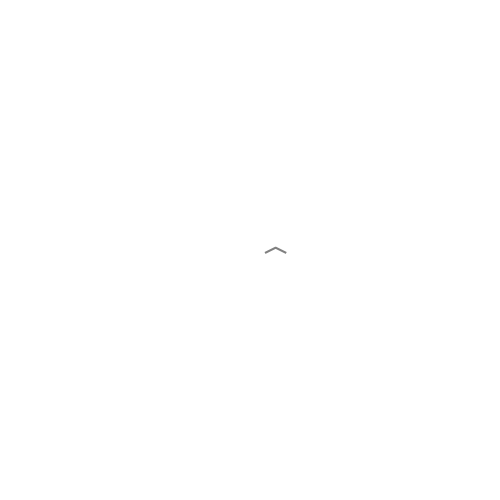

181 [24. 62. 48. 47.] [30. 32.]
elapsed time sec 0.20411569999998846
Dice Ns Flag1 Flag2 isx ismax 729 1 2 724 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


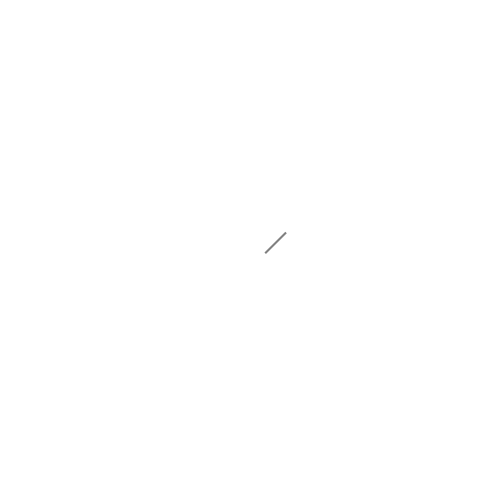

181 [20. 54. 44. 63.] [14. 40.]
elapsed time sec 0.10126669999999649
Dice Ns Flag1 Flag2 isx ismax 729 1 1 52 52
Refine time ig jg Nc Ncx 21:55:59 3 8 508 52
Refine time ig jg Nc Ncx 21:55:59 4 9 540 508
IterRefine iter Ncx 0 540
Refine time ig jg Nc Ncx 21:55:59 1 1 548 540
Refine time ig jg Nc Ncx 21:55:59 2 4 556 548
Refine time ig jg Nc Ncx 21:55:59 2 5 572 556
Refine time ig jg Nc Ncx 21:55:59 2 8 620 572
IterRefine iter Ncx 1 620
Refine time ig jg Nc Ncx 21:55:59 1 7 636 620
Refine time ig jg Nc Ncx 21:55:59 1 11 652 636
Refine time ig jg Nc Ncx 21:55:59 2 4 700 652
Refine time ig jg Nc Ncx 21:55:59 3 3 708 700
IterRefine iter Ncx 2 708
IterRefine iter Ncx 3 708
Refine time ig jg Nc Ncx 21:56:00 2 2 724 708
IterRefine iter Ncx 4 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


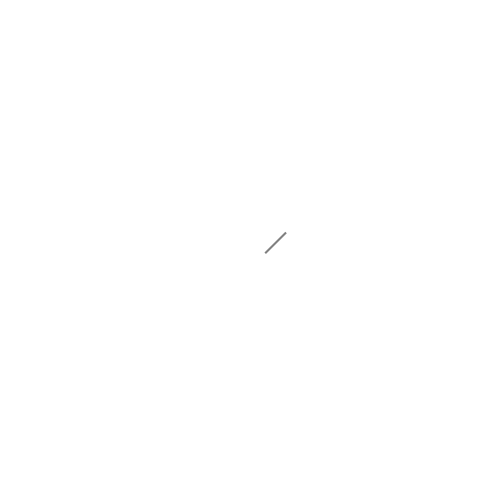

181 [40. 56. 52. 33.] [20. 36.]
elapsed time sec 1.0639009000000215
Dice Ns Flag1 Flag2 isx ismax 729 1 1 116 116
Refine time ig jg Nc Ncx 21:56:00 3 6 172 116
Refine time ig jg Nc Ncx 21:56:00 3 10 604 172
IterRefine iter Ncx 0 604
Refine time ig jg Nc Ncx 21:56:00 1 3 620 604
Refine time ig jg Nc Ncx 21:56:00 1 4 636 620
Refine time ig jg Nc Ncx 21:56:00 1 15 700 636
IterRefine iter Ncx 1 700
IterRefine iter Ncx 2 700
Refine time ig jg Nc Ncx 21:56:01 3 3 708 700
IterRefine iter Ncx 3 708
Refine time ig jg Nc Ncx 21:56:01 2 2 724 708
IterRefine iter Ncx 4 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


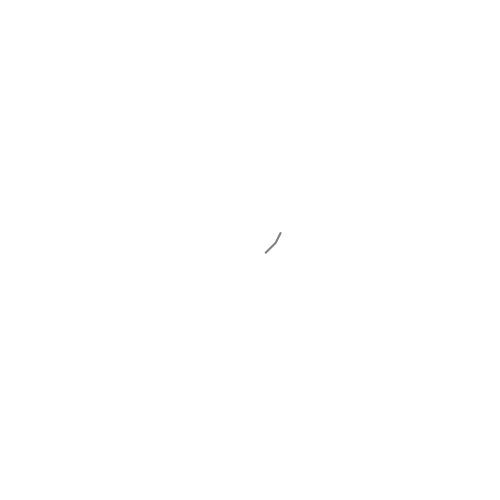

181 [40. 62. 32. 47.] [30. 32.]
elapsed time sec 1.0786511000000019
Dice Ns Flag1 Flag2 isx ismax 729 1 2 692 692
IterRefine iter Ncx 0 692
Refine time ig jg Nc Ncx 21:56:01 2 16 708 692
IterRefine iter Ncx 1 708
Refine time ig jg Nc Ncx 21:56:02 1 16 724 708
IterRefine iter Ncx 2 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


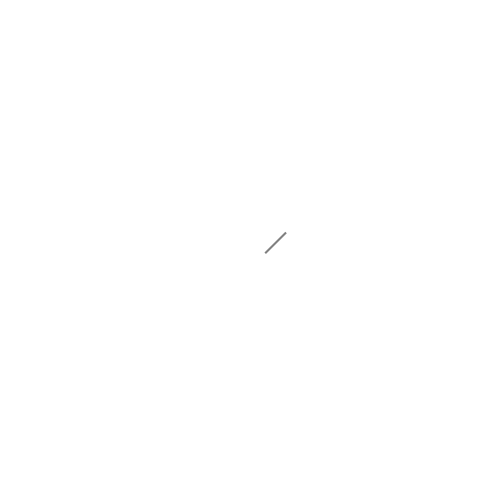

181 [52. 50. 52. 27.] [26. 24.]
elapsed time sec 0.7152507000000128
Dice Ns Flag1 Flag2 isx ismax 729 1 1 68 68
Refine time ig jg Nc Ncx 21:56:02 2 10 76 68
Refine time ig jg Nc Ncx 21:56:02 2 11 84 76
Refine time ig jg Nc Ncx 21:56:02 3 11 572 84
IterRefine iter Ncx 0 572
Refine time ig jg Nc Ncx 21:56:02 1 6 588 572
Refine time ig jg Nc Ncx 21:56:02 1 10 604 588
Refine time ig jg Nc Ncx 21:56:02 1 12 620 604
Refine time ig jg Nc Ncx 21:56:02 1 13 636 620
Refine time ig jg Nc Ncx 21:56:02 1 15 652 636
IterRefine iter Ncx 1 652
Refine time ig jg Nc Ncx 21:56:02 3 3 724 652
IterRefine iter Ncx 2 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


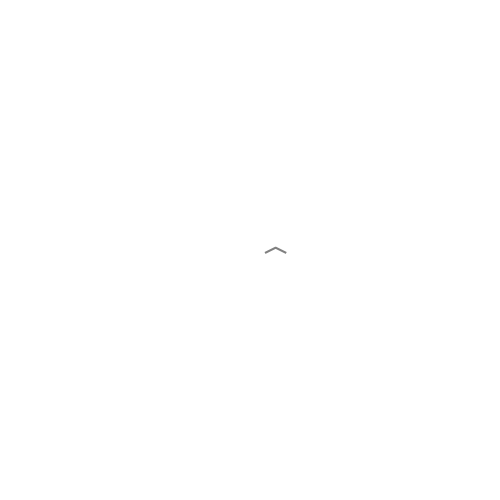

181 [44. 72. 40. 25.] [24. 48.]
elapsed time sec 0.56159260000004
Dice Ns Flag1 Flag2 isx ismax 729 1 2 692 692
Refine time ig jg Nc Ncx 21:56:02 3 5 724 692
IterRefine iter Ncx 0 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


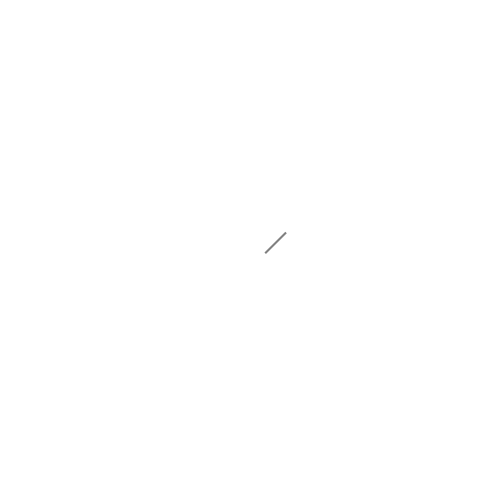

181 [40. 50. 24. 67.] [22. 28.]
elapsed time sec 0.2617501999999945
Dice Ns Flag1 Flag2 isx ismax 729 1 1 356 356
Refine time ig jg Nc Ncx 21:56:03 1 2 452 356
Refine time ig jg Nc Ncx 21:56:03 1 9 612 452
Refine time ig jg Nc Ncx 21:56:03 1 17 644 612
Refine time ig jg Nc Ncx 21:56:03 2 10 724 644
IterRefine iter Ncx 0 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


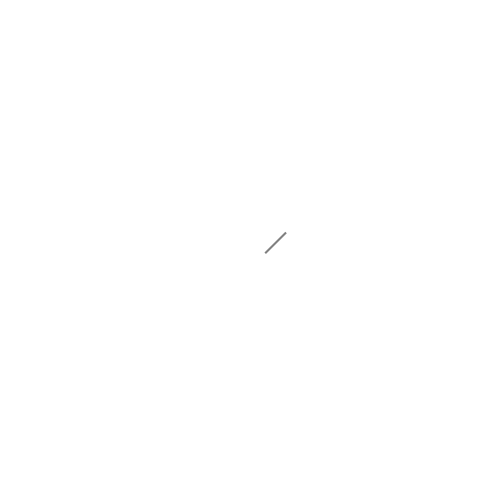

181 [24. 76. 44. 37.] [36. 40.]
elapsed time sec 0.2555132999999614
Dice Ns Flag1 Flag2 isx ismax 729 1 1 188 188
Refine time ig jg Nc Ncx 21:56:03 1 16 604 188
Refine time ig jg Nc Ncx 21:56:03 2 14 684 604
IterRefine iter Ncx 0 684
Refine time ig jg Nc Ncx 21:56:03 1 1 692 684
Refine time ig jg Nc Ncx 21:56:03 1 8 708 692
Refine time ig jg Nc Ncx 21:56:03 1 9 724 708
IterRefine iter Ncx 1 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


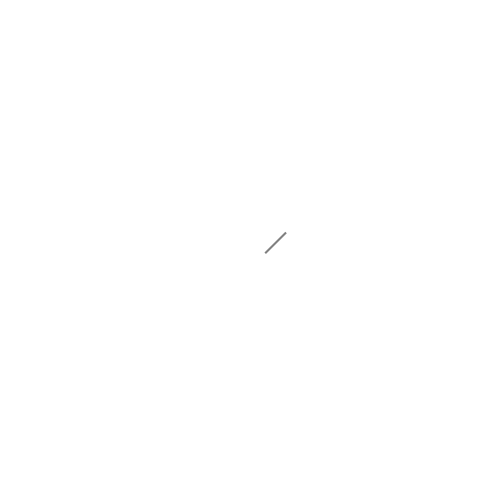

181 [36. 72. 48. 25.] [24. 48.]
elapsed time sec 0.3703950999999961
Dice Ns Flag1 Flag2 isx ismax 729 1 2 692 692
Refine time ig jg Nc Ncx 21:56:03 2 5 724 692
IterRefine iter Ncx 0 724
Ncx, Ns NBlnk 724 729 0
ND Ns Ncx 19 729 724
724 0


<IPython.core.display.Javascript object>


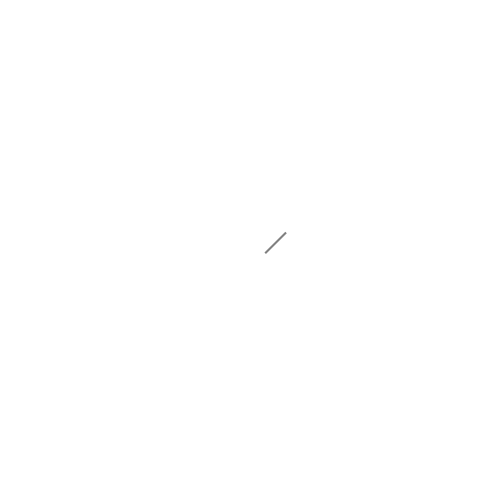

181 [32. 74. 40. 35.] [30. 44.]
elapsed time sec 0.2290403000000083
elapsedtime [0.20411569999998846, 0.10126669999999649, 1.0639009000000215, 1.0786511000000019, 0.7152507000000128, 0.56159260000004, 0.2617501999999945, 0.2555132999999614, 0.3703950999999961, 0.2290403000000083]


In [7]:
ND = 19
krRef = 0.3
Kp = 0.01
Ki = 0.0001
Nthr = 1
elapsedtime = []
for i in range (10):
    start = timer()
    GMa, xtot, xacc, x2acc = generatekolam (ND, krRef, Kp, Ki, Nthr)

    if GMa != 0:
        end = timer()
        elapsedtime.append (end-start)
        print('elapsed time sec',end - start)
        #print (GMa)
        with open('kolam19hexGH.txt', 'a') as f:
            f.write(GMa)
            f.write("\n")
print ('elapsedtime', elapsedtime)